In [1]:
import torch
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import matplotlib.pyplot as plt
import numpy as np


In [49]:
def setup_diffusion_pipeline():
    """Set up the Stable Diffusion pipeline."""
    pipe = StableDiffusionPipeline.from_pretrained("nota-ai/bk-sdm-v2-tiny", torch_dtype=torch.float16)

    # Move to appropriate device
    if torch.cuda.is_available():
        pipe = pipe.to("cuda")
    elif torch.backends.mps.is_available():
        pipe = pipe.to("mps")
    else:
        pipe = pipe.to("cpu")

    return pipe

def generate_baseline_image(pipe, prompt, seed=8, steps=5):
    """
    Generate an image with the sd model.

    Args:
        pipe: Stable Diffusion pipeline
        prompt: Text prompt for generation
        seed: Random seed for reproducibility
        steps: Number of inference steps

    Returns:
        image: Generated PIL image
    """
    # TODO: Generate an image using the pipeline
    # - Create a generator with the given seed
    #   - generator=torch.Generator(device=device).manual_seed(seed)
    # - Call the pipeline with prompt and parameters
    # - Return the first generated image
    # generator = torch.Generator(device='cpu').manual_seed(seed)
    # images = pipe(prompt, num_inference_steps=steps, generator=generator)
    # return images.images[0]
    device = pipe.device.type
    generator = torch.Generator(device=device).manual_seed(seed)
    image = pipe(prompt, num_inference_steps=steps, generator=generator).images[0]
    return image


# Set up and test
pipe = setup_diffusion_pipeline()
prompt = "a black vase holding a bouquet of roses"
baseline_image = generate_baseline_image(pipe, prompt)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

cuda


  0%|          | 0/5 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7EB46D337310>


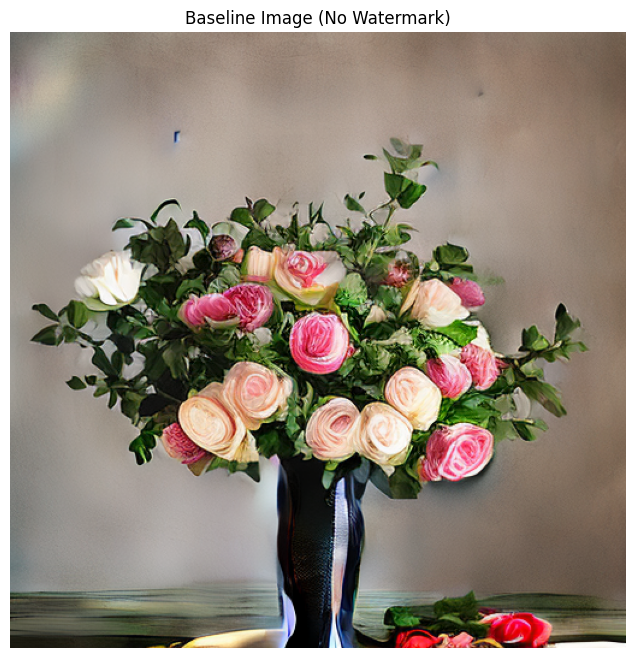

In [48]:
image = baseline_image
print(image)
plt.figure(figsize=(8, 8))
plt.imshow(np.array(image))
plt.title("Baseline Image (No Watermark)")
plt.axis('off')
plt.show()

# Save for comparison
image.save("baseline_image.png")

  0%|          | 0/5 [00:00<?, ?it/s]

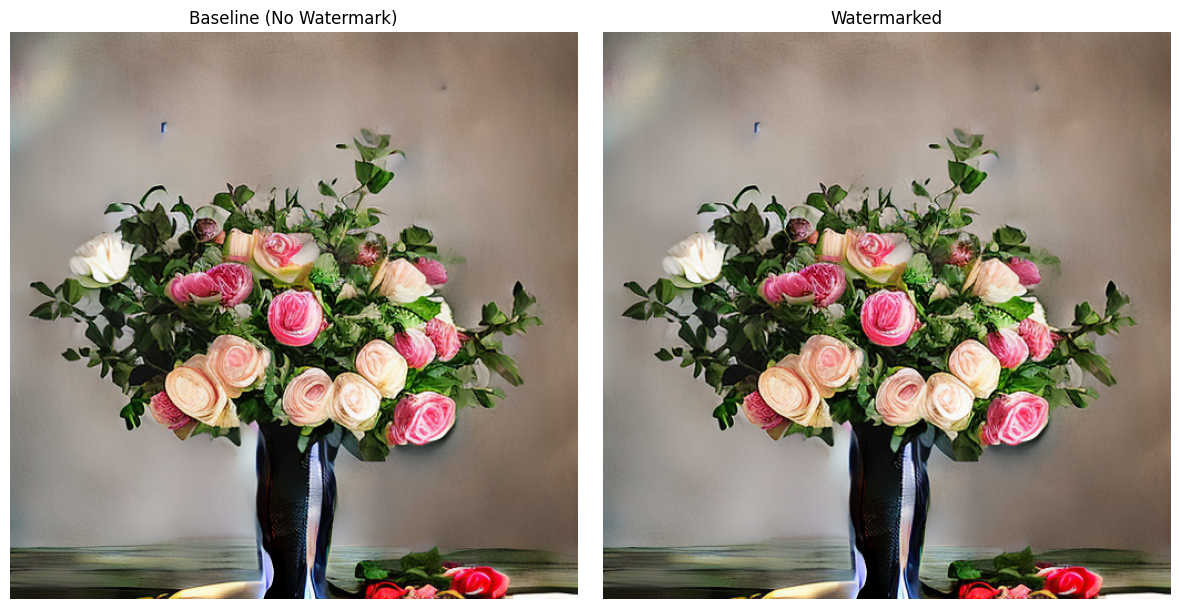

In [50]:

class FrequencyWatermarker:
    """Watermarker that modifies specific frequency bands in UNet outputs."""

    def __init__(self):
        """
        Initialize the watermarker.
        """
        self.hook_handle = None

    def watermark_hook(self, module, input, output):
        """
        Hook function that modifies UNet output in frequency domain.

        This function is called during the forward pass of the UNet.
        """
        # TODO: Implement frequency domain watermarking
        # - Extract the correct tensor from the output
        #   - write an adhoc hook and look at the model outputs to check
        #   - look at the implementation to see what is happening under the hood in the SD pipeline
        #   - ask a TA / check solution to  make sure you are looking at the correct tensor
        # - Apply 2D FFT and shift
        # - Modify frequencies
        #   - to start, just multiply the rectangle [:, 10:30] or similar with 0.98
        #   - You can move to more fancy and less discernible watermarks after you have completed this exercise
        # - Apply inverse FFT and modify the hook output

        # val = output[0][1].to(dtype=torch.float32)
        # val = torch.fft.fftshift(val, dim=(-2, -1))
        # val = torch.fft.fft2(val)
        # val[:, 10:30, :] *= 0.95
        # val = torch.fft.ifftshift(val, dim=(-2, -1))
        # output[0][1] = torch.fft.ifft2(val).real
        # return output
        to_update = output[0][1].to(dtype=torch.float32)

        # Convert to frequency domain
        fft_output = torch.fft.fft2(to_update)
        fft_shifted = torch.fft.fftshift(fft_output, dim=(-2, -1))

        # Modify specific frequency band
        start, end = (10,30)
        fft_shifted[:, start:end, :] *= 0.999

        # Convert back to spatial domain
        fft_unshifted = torch.fft.ifftshift(fft_shifted, dim=(-2, -1))
        spatial_output = torch.fft.ifft2(fft_unshifted)

        # Update the output
        output[0][1] = spatial_output.real

        return output

    def attach(self, unet):
        self.hook_handle = unet.register_forward_hook(self.watermark_hook)

    def detach(self):
        if self.hook_handle:
            self.hook_handle.remove()
            self.hook_handle = None


def generate_watermarked_image(pipe, prompt, watermarker, seed=8, steps=5):
    """Generate an image with watermarking applied."""
    # Extract UNet from pipeline
    unet = pipe.components['unet']

    # Attach watermarker
    watermarker.attach(unet)

    try:
        # Generate image
        device = pipe.device.type
        generator = torch.Generator(device=device).manual_seed(seed)
        image = pipe(prompt, num_inference_steps=steps, generator=generator).images[0]
    finally:
        # Always detach the watermarker
        watermarker.detach()

    return image

# Test watermarking
watermarker = FrequencyWatermarker()
watermarked_image = generate_watermarked_image(pipe, prompt, watermarker)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(np.array(baseline_image))
axes[0].set_title("Baseline (No Watermark)")
axes[0].axis('off')

axes[1].imshow(np.array(watermarked_image))
axes[1].set_title("Watermarked")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save watermarked image
watermarked_image.save("watermarked_image.png")

Analyzing frequency domain differences...


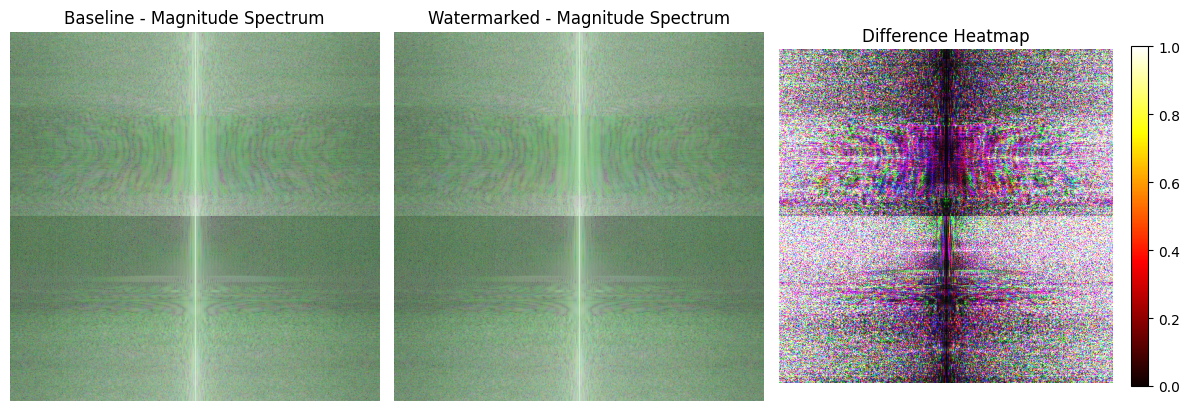


Watermark Analysis:
Maximum difference in frequency domain: 26.7613
Mean difference in frequency domain: 1.0000


In [51]:

def compute_fft_magnitude_spectrum(image):
    """
    Compute the magnitude spectrum of an image's FFT.

    Args:
        image: PIL Image or numpy array

    Returns:
        magnitude_spectrum: Log magnitude spectrum (in dB)
        fft_shifted: Shifted FFT for further analysis
    """
    # TODO: Implement FFT magnitude spectrum computation
    # - Convert image to numpy array
    # - Apply 2D FFT and shift
    # - Compute magnitude in dB (20 * log)
    arr = np.array(image)
    fft = np.fft.fft2(arr)
    fft = np.fft.fftshift(fft)
    magn = 20 * np.log(np.abs(fft) + 0.00000000001)
    return magn, fft

def visualize_frequency_comparison(baseline_image, watermarked_image):
    """Visualize and compare frequency domains of baseline and watermarked images."""
    # Compute FFT for both images
    mag_baseline, fft_baseline = compute_fft_magnitude_spectrum(baseline_image)
    mag_watermarked, fft_watermarked = compute_fft_magnitude_spectrum(watermarked_image)

    # Normalize for visualization
    min_mag = min(mag_baseline.min(), mag_watermarked.min())
    max_mag = max(mag_baseline.max(), mag_watermarked.max())

    mag_baseline_norm = (mag_baseline - min_mag) / (max_mag - min_mag)
    mag_watermarked_norm = (mag_watermarked - min_mag) / (max_mag - min_mag)

    # Create comparison plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 10))

    # Magnitude spectra
    axes[0].imshow(mag_baseline_norm, cmap='gray')
    axes[0].set_title('Baseline - Magnitude Spectrum')
    axes[0].axis('off')

    axes[1].imshow(mag_watermarked_norm, cmap='gray')
    axes[1].set_title('Watermarked - Magnitude Spectrum')
    axes[1].axis('off')

    # Difference heatmap
    magnitude_diff = np.abs(mag_baseline_norm - mag_watermarked_norm)
    magnitude_diff = magnitude_diff / (magnitude_diff.mean() + 1e-8)  # Normalize

    im = axes[2].imshow(magnitude_diff, cmap='hot')
    axes[2].set_title('Difference Heatmap')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    plt.show()

    return magnitude_diff

# Analyze the watermark
print("Analyzing frequency domain differences...")
diff_map = visualize_frequency_comparison(baseline_image, watermarked_image)

# Print statistics
print(f"\nWatermark Analysis:")
print(f"Maximum difference in frequency domain: {diff_map.max():.4f}")
print(f"Mean difference in frequency domain: {diff_map.mean():.4f}")

Testing watermark robustness...


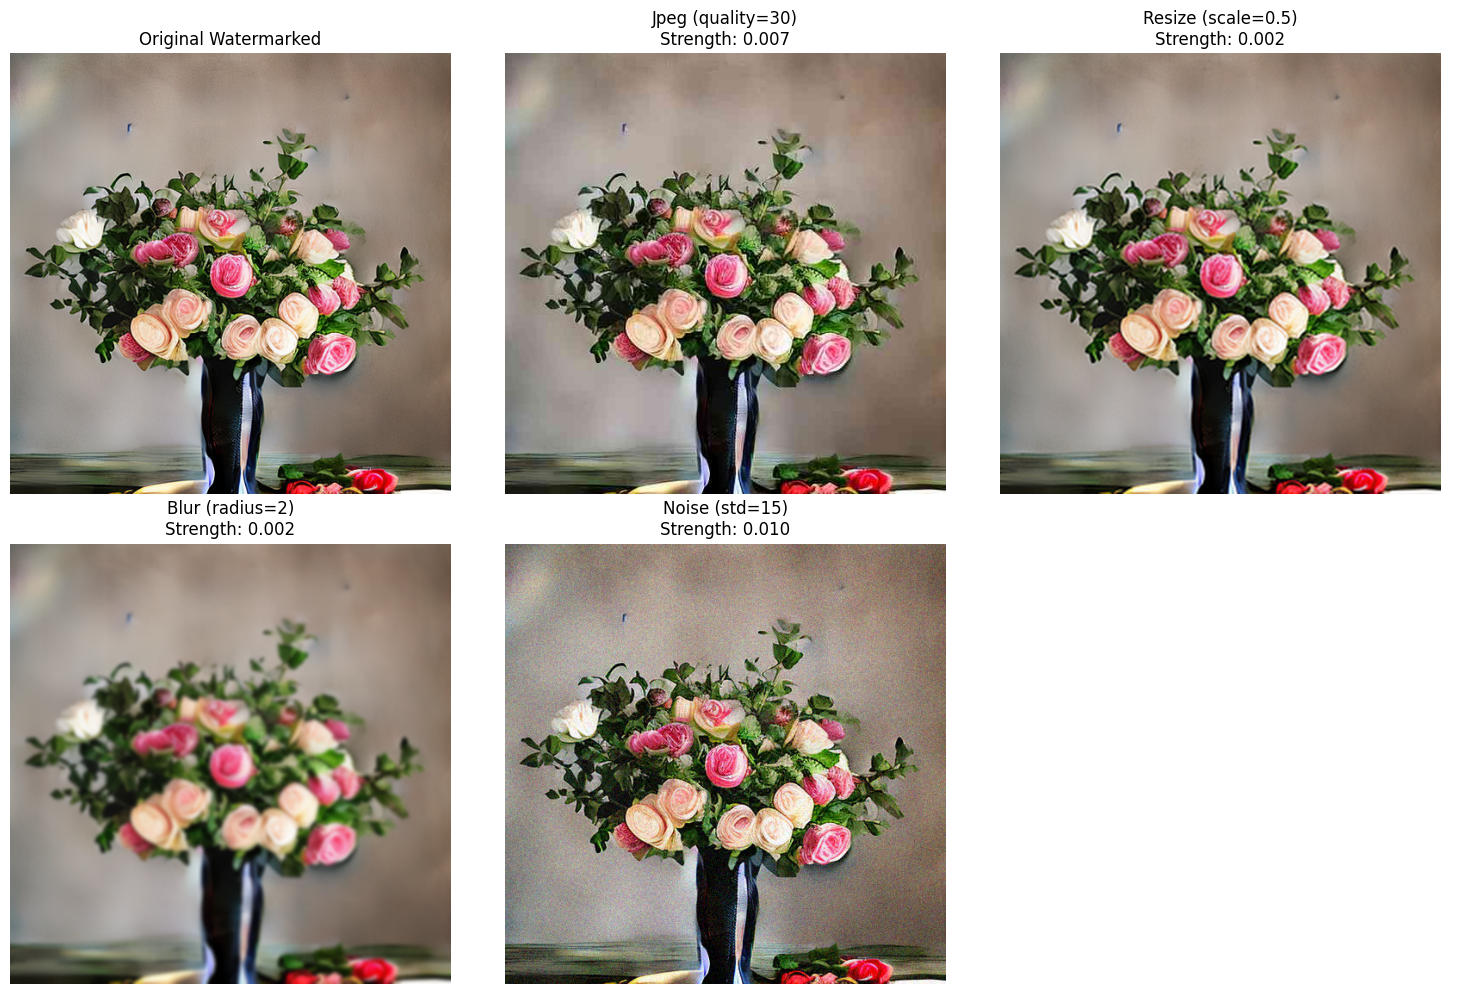


Robustness Summary:
Jpeg: strength = 0.0071
  ✗ Watermark lost
Resize: strength = 0.0024
  ✗ Watermark lost
Blur: strength = 0.0019
  ✗ Watermark lost
Noise: strength = 0.0105
  ✓ Watermark detected


In [52]:

from PIL import Image, ImageFilter
import io

def apply_image_transformation(image, transform_type, **kwargs):
    """
    Apply various transformations to test watermark robustness.

    Args:
        image: PIL Image
        transform_type: One of ['jpeg', 'resize', 'blur', 'noise']
        **kwargs: Additional parameters for the transformation

    Returns:
        transformed_image: Transformed PIL Image
    """
    if transform_type == 'jpeg':
        # JPEG compression
        quality = kwargs.get('quality', 50)
        buffer = io.BytesIO()
        image.save(buffer, format='JPEG', quality=quality)
        buffer.seek(0)
        return Image.open(buffer)

    elif transform_type == 'resize':
        # Resize down and back up
        scale = kwargs.get('scale', 0.5)
        orig_size = image.size
        small_size = (int(orig_size[0] * scale), int(orig_size[1] * scale))
        return image.resize(small_size, Image.Resampling.LANCZOS).resize(orig_size, Image.Resampling.LANCZOS)

    elif transform_type == 'blur':
        # Gaussian blur
        radius = kwargs.get('radius', 2)
        return image.filter(ImageFilter.GaussianBlur(radius=radius))

    elif transform_type == 'noise':
        # Add Gaussian noise
        std = kwargs.get('std', 10)
        img_array = np.array(image).astype(float)
        noise = np.random.normal(0, std, img_array.shape)
        noisy = np.clip(img_array + noise, 0, 255).astype(np.uint8)
        return Image.fromarray(noisy)

def check_watermark_robustness(baseline_image, watermarked_image):
    """Test watermark detection after various transformations."""
    transformations = [
        ('jpeg', {'quality': 30}),
        ('resize', {'scale': 0.5}),
        ('blur', {'radius': 2}),
        ('noise', {'std': 15})
    ]

    results = []

    for transform_type, params in transformations:
        # Apply transformation to both images
        transformed_baseline = apply_image_transformation(baseline_image, transform_type, **params)
        transformed_watermarked = apply_image_transformation(watermarked_image, transform_type, **params)

        # Compute FFT difference
        mag_base, _ = compute_fft_magnitude_spectrum(transformed_baseline)
        mag_water, _ = compute_fft_magnitude_spectrum(transformed_watermarked)

        # Normalize and compute difference
        min_mag = min(mag_base.min(), mag_water.min())
        max_mag = max(mag_base.max(), mag_water.max())
        mag_base_norm = (mag_base - min_mag) / (max_mag - min_mag + 1e-8)
        mag_water_norm = (mag_water - min_mag) / (max_mag - min_mag + 1e-8)

        diff = np.abs(mag_base_norm - mag_water_norm)

        # Measure watermark strength in the target frequency band
        center = np.array(diff.shape) // 2
        y, x = np.ogrid[:diff.shape[0], :diff.shape[1]]

        # Create mask for frequency band 3-25
        dist_from_center = np.sqrt((x - center[1])**2 + (y - center[0])**2)
        band_mask = (dist_from_center >= 3) & (dist_from_center <= 25)

        watermark_strength = diff[band_mask].mean() if band_mask.any() else 0

        results.append({
            'transform': transform_type,
            'params': params,
            'strength': watermark_strength,
            'transformed_image': transformed_watermarked
        })

    return results

# Test robustness
print("Testing watermark robustness...")
robustness_results = check_watermark_robustness(baseline_image, watermarked_image)

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original watermarked image
axes[0].imshow(np.array(watermarked_image))
axes[0].set_title('Original Watermarked')
axes[0].axis('off')

# Transformed images
for i, result in enumerate(robustness_results):
    axes[i+1].imshow(np.array(result['transformed_image']))
    transform_name = f"{result['transform'].capitalize()}"
    param_str = ', '.join(f"{k}={v}" for k, v in result['params'].items())
    axes[i+1].set_title(f'{transform_name} ({param_str})\nStrength: {result["strength"]:.3f}')
    axes[i+1].axis('off')

# Hide unused subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

# Summary
print("\nRobustness Summary:")
print("="*50)
for result in robustness_results:
    print(f"{result['transform'].capitalize()}: strength = {result['strength']:.4f}")
    if result['strength'] > 0.01:
        print("  ✓ Watermark detected")
    else:
        print("  ✗ Watermark lost")